<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "5B"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/5B/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


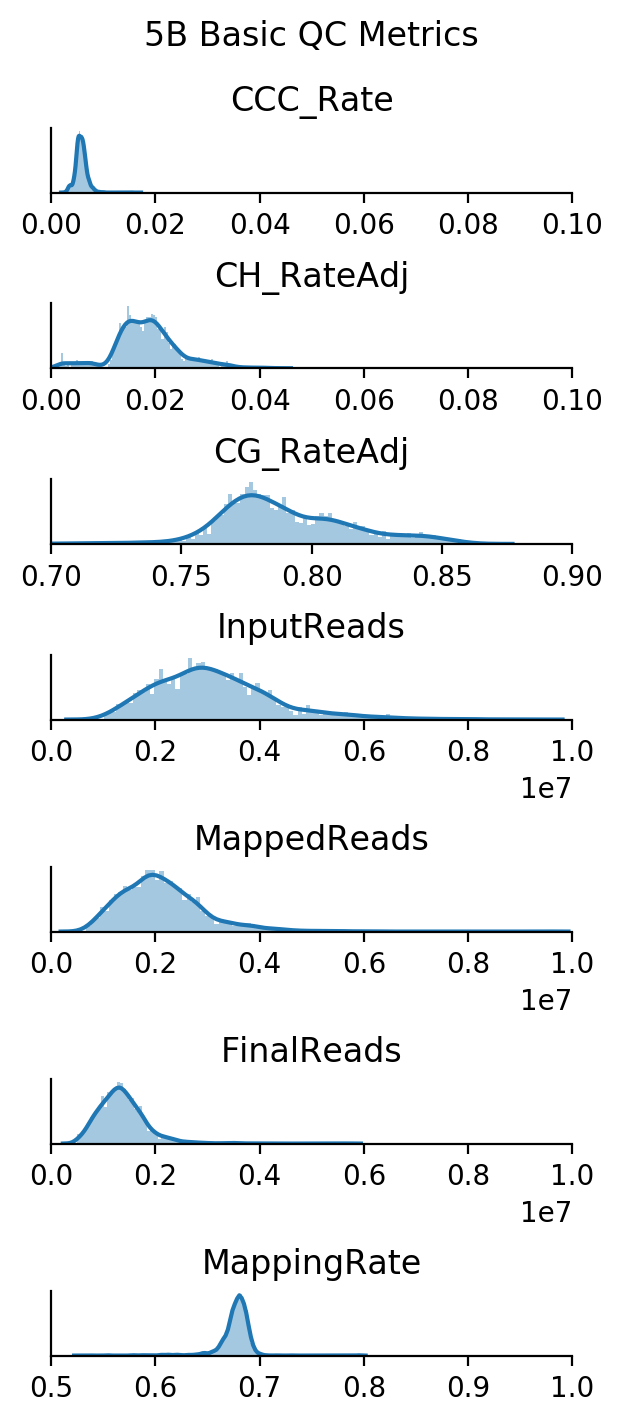

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

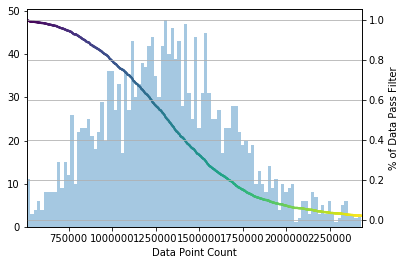

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1986/1986 (100.0%)
CG_RateAdj passed 1986/1986 (100.0%)
CH_RateAdj passed 1986/1986 (100.0%)
FinalReads passed 1986/1986 (100.0%)
MappingRate passed 1986/1986 (100.0%)
Overall passed 1986/1986 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180514 840
180529 1146


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 239 62.2%
ad002 267 69.5%
ad004 227 59.1%
ad006 233 60.7%
ad007 250 65.1%
ad008 252 65.6%
ad010 244 63.5%
ad012 274 71.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
5B_M_0,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180514_5B...,0.00589,0.77939,0.77808,0.02552,0.01975,931606.0,2113692,1381068.0,5B,...,-0.264186,-14.755128,2.265745,57.512012,IT-L23 Cux1,-0.994649,11.369860,7.897881,-45.893701,True
5B_M_10,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180514_5B...,0.00599,0.80266,0.80147,0.02430,0.01842,1824054.0,4454738,3018838.0,5B,...,23.422363,4.492110,-19.612431,-8.899475,CT-L6 Tnr,-9.849323,-23.406887,-45.857484,7.216373,True
5B_M_100,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180514_5B...,0.00534,0.80286,0.80180,0.02160,0.01635,700666.0,1419698,960620.0,5B,...,21.657244,5.243433,-42.734058,-10.943459,CT-L6 Megf9,-6.922263,-11.445531,-9.815247,30.452211,True
5B_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180529_5B...,0.00392,0.76426,0.76333,0.00893,0.00503,1739189.0,3969474,2677697.0,5B,...,-9.185815,9.545619,-13.513975,-25.759792,ASC cortex-olf,1.165426,5.467535,9.613997,20.142142,True
5B_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180529_5B...,0.00389,0.76188,0.76095,0.01220,0.00834,1666506.0,3886042,2574104.0,5B,...,4.201618,-10.658834,38.495037,-0.905738,ODC odc-small,5.482989,0.910059,9.482468,-22.577665,True
5B_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180529_5B...,0.00325,0.73527,0.73441,0.00506,0.00182,1619328.0,3766550,2520629.0,5B,...,-2.836804,0.296259,4.546919,46.288827,MGC mgc-all,2.756835,-2.913054,-6.309855,-3.251656,True
5B_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180529_5B...,0.00671,0.81665,0.81541,0.03047,0.02392,853585.0,1720376,1167722.0,5B,...,13.055090,-13.590273,25.458784,26.164440,IT-L5 Etv1,9.492785,4.398130,-28.263143,5.147300,True
5B_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180529_5B...,0.00647,0.77934,0.77790,0.02690,0.02056,584756.0,1133222,781712.0,5B,...,7.607364,-15.060996,6.423386,29.335678,IT-L5 Cdh8,3.477566,13.358541,-3.656332,-38.234389,True
5B_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180529_5B...,0.00621,0.80507,0.80385,0.02517,0.01908,861441.0,1724448,1180357.0,5B,...,2.980527,-18.966194,-59.193873,4.151965,IT-L4 Astn2,-0.155229,11.868662,15.396279,-41.266958,True
5B_M_1006,/gale/raidix/rdx-4/CEMBA_RS1/5B/CEMBA180529_5B...,0.00519,0.77509,0.77392,0.01956,0.01444,774392.0,1564934,1070548.0,5B,...,3.836818,-17.220711,-40.192608,12.486527,IT-L4 Astn2,-0.358778,4.915119,17.759354,-6.275790,True
